In [1]:
#import ml packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer



from sklearn.feature_extraction.text import CountVectorizer
import sklearn.model_selection as model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from xgboost import XGBClassifier

In [2]:
#import dataset
train_df = pd.read_csv('../AskReddit Dataset/train.csv')
test_df = pd.read_csv('../AskReddit Dataset/test.csv')
train_df.head()

,qid,question_text,target
0,a3dee568776c08512c89,What is the role of Lua in Civ4?,0
1,bdb84f519e7b46e7b7bb,What are important chapters in Kannada for 10 ...,0
2,29c88db470e2eb5c97ad,Do musicians get royalties from YouTube?,0
3,3387d99bf2c3227ae8f1,What is the difference between Scaling Social ...,0
4,e79fa5038f765d0f2e7e,Why do elevators go super slow right before th...,0


In [3]:
# choose elements from df where target = 1
pd.set_option('display.max_colwidth', 100)
df_1 = train_df[train_df['target'] == 1]
df_1["question_text"]

16                                                     What stupid things do Indians do when in your country?
31                             Can I sue my parents for giving birth to me when I did not want them to do so?
32                          What are your views about sexual relationship between a widow mother and her son?
33        You became an atheist, and after 2 years you fall and break your back. You are left paralyzed fr...
90                                    Why aren't we protesting for government control instead of gun control?
                                                         ...                                                 
652967              What is a liberal's understanding of the difference between pollution and climate change?
653021    Do unattractive or average-looking men ever get a girlfriend who actually loves them or do they ...
653029                                                                   How can I grab my aunties boobs! :p?
653034    

In [4]:
# see value count order of target
train_df['target'].value_counts()

0    612656
1     40405
Name: target, dtype: int64

In [5]:
# percentage of troll questions in the dataset
train_df['target'].value_counts(normalize=True)

0    0.93813
1    0.06187
Name: target, dtype: float64

<AxesSubplot:xlabel='target', ylabel='count'>

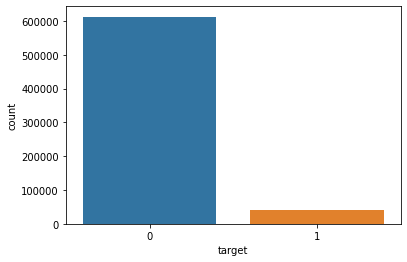

In [85]:
# graphing label counts
sns.countplot(x='target', data=train_df)

<AxesSubplot:xlabel='target'>

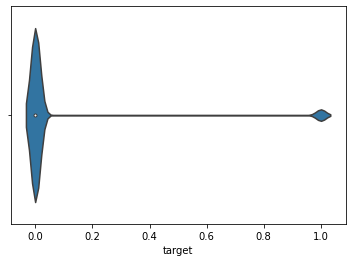

In [86]:
# violin plot of label value counts
sns.violinplot(x='target', data=train_df, hue='target')

In [69]:
# create a preprocessing class
class Preprocessor:
    
    def __init__(self,df) -> None:
        self.df = df

    # convert all charecters to lower case
    def convertToLower(self):
        self.df['question_text'] = self.df['question_text'].apply(lambda x: x.lower())
        return self.df

    # remove stop words
    def removeStopWords(self):
        stop = stopwords.words('english')
        self.df['question_text'] = self.df['question_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
        return self.df


    # remove punctuation
    def removePunctuation(self):
        self.df['question_text'] = self.df['question_text'].str.replace('[^\w\s]','')
        return self.df

    # remove numbers
    def removeNumbers(self):
        self.df['question_text'] = self.df['question_text'].str.replace('[0-9]','')
        return self.df

    # remove whitespaces
    def removeWhitespaces(self):
        self.df['question_text'] = self.df['question_text'].apply(lambda x: ' '.join(x.split()))
        return self.df

    # remove urls
    def removeURLs(self):
        self.df['question_text'] = self.df['question_text'].str.replace('https?://\S+|www\.\S+','')
        return self.df
        

    # stemmer algorithm
    def stemmer(self):
        stemmer = SnowballStemmer()
        def stem_words(text):
            return " ".join([stemmer.stem(word) for word in text.split()])  
        self.df["question_text"] = self.df["question_text"].apply(lambda x: stem_words(x))
        return self.df


    # lemmatizing
    def lemmatize(self):
        from nltk.stem import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        def lemmatize_words(text):
            return " ".join([lemmatizer.lemmatize(word) for word in text.split()])  
        self.df["question_text"] = self.df["question_text"].apply(lambda x: lemmatize_words(x))
        return self.df

    # remove id and index columns
    def removeUnwantedCols(self,col):
        print(self.df.shape)
        self.df = self.df.drop(col,axis=1)
        return self.df
    
    def preprocess(self):
        # self.df = self.convertToLower()
        # self.df = self.removeStopWords()
        # self.df = self.removePunctuation()
        # self.df = self.removeNumbers()
        # self.df = self.removeURLs()
        # self.df = self.removeWhitespaces()
        # self.df = self.stemmer()
        # self.df = self.lemmatize()
        self.df = self.removeUnwantedCols(['qid'])
        return self.df

In [70]:
preproccesor = Preprocessor(train_df)
preprocessed_df = preproccesor.preprocess()
preprocessed_df.head()

(653061, 3)


,question_text,target
0,role lua civ,0
1,important chapters kannada icse,0
2,musicians get royalties youtube,0
3,difference scaling social enterprises social franchising,0
4,elevators go super slow right doors open,0


In [71]:
# get shape of preprocessed_df
preprocessed_df.shape

(653061, 2)

In [72]:
# create a get train and test data class
class TrainTestData:

    def __init__(self,trainDf,testDf) -> None:
        self.trainDf = trainDf
        self.testDf = testDf

    
    def get_X(self,minDocumentCount):
        
        # concatinate trainDf and testDf
        self.appendDf = pd.concat([self.trainDf['question_text'],self.testDf['question_text']],axis=0)
        
        vectorizer = CountVectorizer()
        vectorizer.fit(self.appendDf)

        self.trainData = vectorizer.transform(self.trainDf['question_text'])
        print(self.trainData.shape)

        self.testData = vectorizer.transform(self.testDf['question_text'])
        print(self.testData.shape)
        self.X = self.trainData


    def get_Y(self):
        self.Y = self.trainDf['target']
        return self.Y

    def testTrainSplit(self):
        self.X_train, self.X_test, self.Y_train, self.Y_test = model_selection.train_test_split(self.X, self.Y, test_size=0.2, random_state=0)
        return self.X_train, self.X_test, self.Y_train, self.Y_test

    def get_X_test(self):
        return self.testData

In [73]:
testPreprocessor = Preprocessor(test_df)
preprocessed_test_df = testPreprocessor.preprocess()
preprocessed_test_df.head()

getTTData = TrainTestData(preprocessed_df,preprocessed_test_df)
X = getTTData.get_X(1)
y = getTTData.get_Y()
X_train,X_test,Y_train,Y_test = getTTData.testTrainSplit()

(653061, 2)


C:\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


(653061, 3660031)
(653061, 3660031)


# Binary Classification using logistic regression

In [74]:
from sklearn.linear_model import LogisticRegression
lrModel = LogisticRegression(solver='liblinear',penalty="l1")
lrModel.fit(X_train, Y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [75]:
y_actual = Y_test
cv_preds = lrModel.predict(X_test)
print(cv_preds.shape)
from sklearn.metrics import fbeta_score
fbeta_score(y_actual, cv_preds, average='macro', beta=0.5)

(130613,)


0.7853830815444047

# Linear SVM Classification

In [52]:
# linear svm classification
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(X_train, Y_train)


LinearSVC()

In [53]:
y_actual = Y_test
cv_preds = model.predict(X_test)

from sklearn.metrics import fbeta_score
fbeta_score(y_actual, cv_preds, average='macro', beta=0.5)

0.7799023453739543

# Logistic Regression with cross validation

In [72]:
from sklearn.linear_model import LogisticRegressionCV
lrCvModel = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear')
lrCvModel.fit(X_train, Y_train)

KeyboardInterrupt: 

In [75]:
from sklearn.linear_model import SGDClassifier
sgdModel = SGDClassifier(loss='log', penalty='l1', alpha=0.0001, max_iter=1000, tol=None)
sgdModel.fit(X_train, Y_train)

# Binary classification using Multinomial NB

In [54]:
from sklearn.naive_bayes import MultinomialNB
mulNbClf = MultinomialNB().fit(X_train,Y_train)
mulNbPreds = mulNbClf.predict(X_test)
fbeta_score(Y_test, mulNbPreds, average='macro', beta=0.5)
np.unique(mulNbPreds, return_counts=True)

(array([0, 1], dtype=int64), array([130522,     91], dtype=int64))

# XGBoost Classifier

In [55]:
# fit model no training data
xgbModel = XGBClassifier()
xgbModel.fit(X_train, Y_train)
xgbModel.predict(X_test)

C:\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Creating a csv out of the test data for submission

In [76]:
preprocessed_test_df.shape

(653061, 1)

In [77]:
predictions = lrModel.predict(getTTData.get_X_test())
predictions.shape

(653061,)

In [78]:
np.unique(predictions)

array([0, 1], dtype=int64)

In [79]:
# get number of unique counts of predictions
np.unique(predictions, return_counts=True)

(array([0, 1], dtype=int64), array([627566,  25495], dtype=int64))

In [80]:
# create a submission data frame from preprocessed_test_df and predictions
submission_df = pd.DataFrame({'qid': test_df['qid'], 'target': predictions})

In [81]:
submission_df.head()

,qid,target
0,0a824224322f0a36025f,0
1,28af14c4e4777ce1273e,0
2,6892a52c51103dd95044,0
3,badd9e8886d73fc1fe4e,0
4,4ef178f82a465e4804ae,0


In [82]:
submission_df['target'].value_counts()

0    627566
1     25495
Name: target, dtype: int64

In [46]:
# convert submission_df to admiral_general_aladdin_submission1.csv
submission_df.to_csv('admiral_general_aladdin_submission14_lr.csv', index=False)